# CV Coursework: test_function

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)
- **CW Owner:** Mousuf C Zaman - Student No: 180021356

# Google Colab Setup
Before starting the coursework, we need to run a few commands to set up our environment on Google Colab. 

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account and follow the instructions.

In [11]:
!pip install facenet-pytorch
!pip install opencv-python==4.5.5.64

import os
import sys
import numpy as np
from collections import Counter
from google.colab import drive
from joblib import dump, load
import matplotlib.pyplot as plt
from matplotlib import patches
from sklearn.model_selection import train_test_split
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import random
from skimage import io
from skimage.feature import hog
from skimage import color, exposure, img_as_ubyte
from skimage import io

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
from facenet_pytorch import MTCNN

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
drive.mount('/content/drive')

!pip install opencv-python==4.5.5.64

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '11 - University/Colab Notebooks/Computer Vision Lab/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

%load_ext autoreload
%autoreload 2

MODEL_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
sys.path.append(MODEL_PATH)

Classifier_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code/Classifier')
sys.path.append(Classifier_PATH)

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
['Code', 'CW_Dataset', 'Models', 'Other', 'Personal_Dataset', 'test_functions.ipynb']


# HOG + MLP Personal Dataset

Streaming output truncated to the last 5000 lines.
Label for train image train/images/image_0574.jpeg : 2
Loading train image: train/images/image_1805.jpeg
Label for train image train/images/image_1805.jpeg : 0
Loading train image: train/images/image_0248.jpeg
Label for train image train/images/image_0248.jpeg : 0
Loading train image: train/images/image_1856.jpeg
Label for train image train/images/image_1856.jpeg : 1
Loading train image: train/images/image_1034.jpeg
Label for train image train/images/image_1034.jpeg : 0
Loading train image: train/images/image_1744.jpeg
Label for train image train/images/image_1744.jpeg : 1
Loading train image: train/images/image_2034.jpeg
Label for train image train/images/image_2034.jpeg : 1
Loading train image: train/images/image_0819.jpeg
Label for train image train/images/image_0819.jpeg : 1
Loading train image: train/images/image_1990.jpeg
Label for train image train/images/image_1990.jpeg : 1
Loading train image: train/images/image_0257.jpeg
Labe

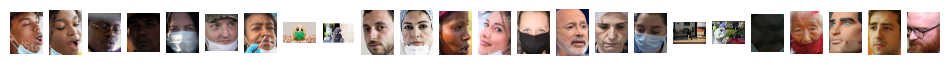

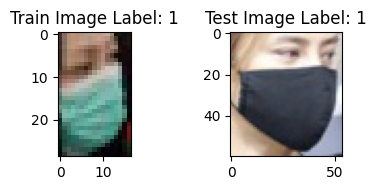

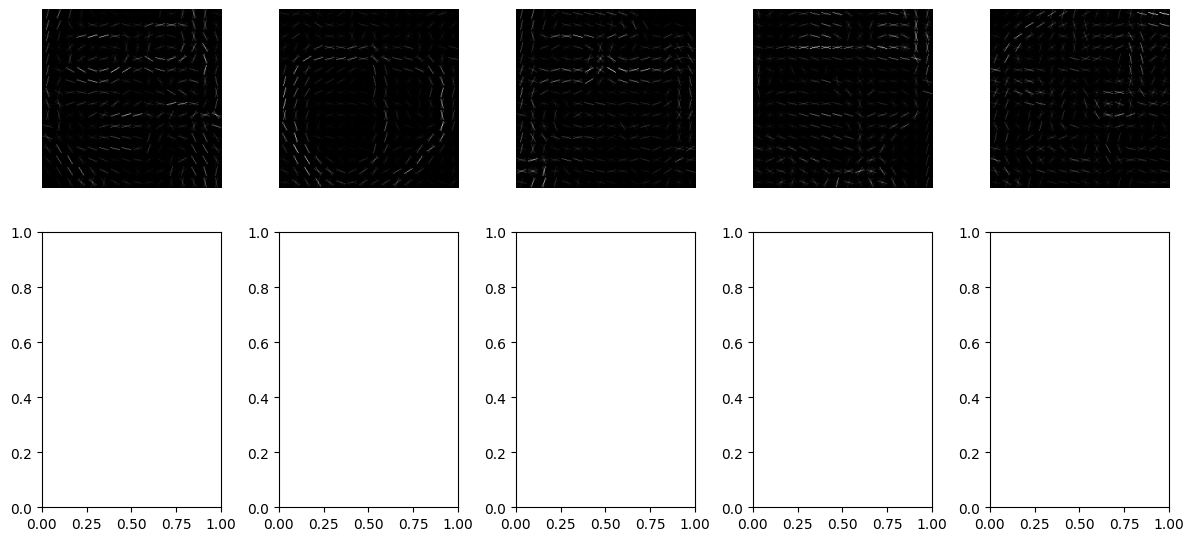

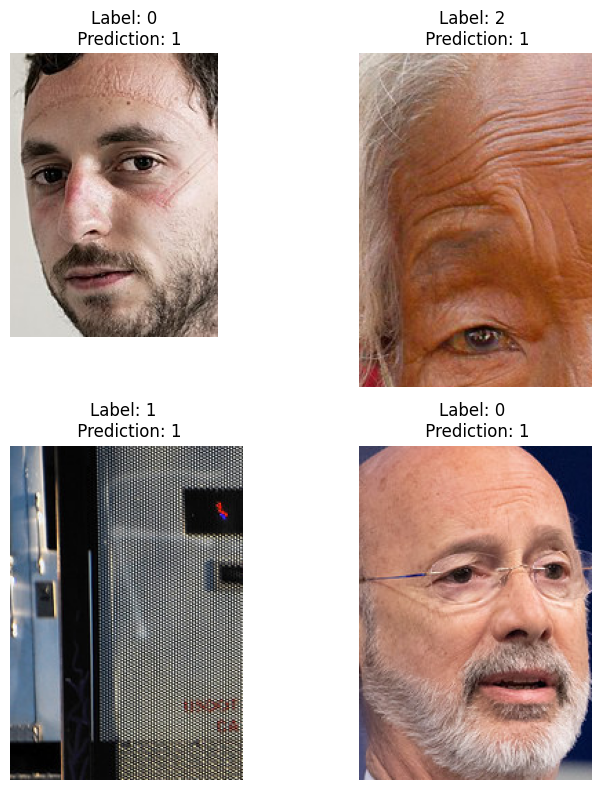

Classification report for classifier MLPClassifier(hidden_layer_sizes=50, learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True):
                    precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.38      1.00      0.55         9
           2       0.00      0.00      0.00         7

    accuracy                           0.38        24
   macro avg       0.12      0.33      0.18        24
weighted avg       0.14      0.38      0.20        24




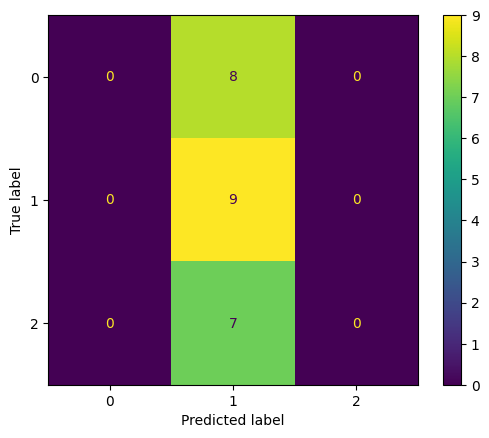

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

# Identify path to zipped dataset
zip_path2 = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset/ownTest.zip')

# Copy it to Colab
!cp '{zip_path2}' .

# Unzip it
!yes|unzip -q ownTest.zip

# Delete zipped version from Colab (not from Drive)
!rm ownTest.zip


##################################################################
# Loading data function

def load_images_and_labels(train_path, test_path, own_test_path):
    images = []
    labels = []
    own_images = []
    own_labels = []

    # Load images and labels from train folder
    train_images_path = os.path.join(train_path, 'images')
    train_labels_path = os.path.join(train_path, 'labels')
    train_img_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpeg')]
    for img_file in train_img_files:
        # Load the image and append to images list
        img_path = os.path.join(train_images_path, img_file)
        print('Loading train image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(train_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            print('Label for train image', img_path, ':', label)
        else:
            print('No label found for train image:', img_path)

    # Load images and labels from test folder
    test_images_path = os.path.join(test_path, 'images')
    test_labels_path = os.path.join(test_path, 'labels')
    test_img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpeg')]
    for img_file in test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(test_images_path, img_file)
        print('Loading test image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            print('Label for test image', img_path, ':', label)
        else:
            print('No label found for test image:', img_path)

    # Load images and labels from own test folder
    own_test_images_path = os.path.join(own_test_path, 'images')
    own_test_labels_path = os.path.join(own_test_path, 'labels')
    own_test_img_files = [f for f in os.listdir(own_test_images_path) if f.endswith('.jpeg')]
    for img_file in own_test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(own_test_images_path, img_file)
        print('Loading own image:', img_path)
        image = io.imread(img_path)

        mtcnn = MTCNN(keep_all=True) 
        # Detect faces in the image
        faces_MTCNN, _ = mtcnn.detect(image, landmarks=False)

        if faces_MTCNN is not None:
            # Only use the first face detected
            face = faces_MTCNN[0]
            # Crop the image to the detected face
            face_img = image[int(face[1]):int(face[3]), int(face[0]):int(face[2])]
            own_images.append(face_img)
        else: 
        # Append the original image as is
          own_images.append(image)    

        # Load the label if it exists and append to labels list
        label_path = os.path.join(own_test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            own_labels.append(label)
            print('Label for own test image', img_path, ':', label)
        else:
            print('No label found for image:', img_path)

    # Count the number of images per label class
    label_counts = Counter(labels + own_labels)
    print('Number of images per label class:', label_counts)

    return images, own_images, labels, own_labels, label_counts


##############################################################################
train_path = 'train'
test_path = 'test'
own_test_path = 'ownTest'
images, X_own_test, labels, y_own_test , label_counts = load_images_and_labels(train_path, test_path, own_test_path)


import matplotlib.pyplot as plt

# plot the images
fig, axes = plt.subplots(nrows=1, ncols=len(X_own_test), figsize=(12, 6))
for i, image in enumerate(X_own_test):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


# Tes if image has loaded correctly
# Generate 1 random index for a train image
train_idx = np.random.choice(range(len(images)), size=1, replace=False)[0]
train_filtered_image = images[train_idx]
train_filtered_label = labels[train_idx]

# Generate 1 random index for a test image
test_index = np.random.choice(range(len(images)-1), size=1, replace=False)[0]
test_filtered_image = images[test_index]
test_filtered_label = labels[test_index]

# Plot the random train image
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
axs[0].imshow(train_filtered_image)
axs[0].set_title('Train Image Label: ' + str(train_filtered_label))

# Plot the random test image
axs[1].imshow(test_filtered_image)
axs[1].set_title('Test Image Label: ' + str(test_filtered_label))

plt.tight_layout()
plt.show()


# Unbalanced problem
# Split the data into training and test sets, stratified by the labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)

# Define target size
target_size = (256, 256)

# Loop over each image in the training set
for i in range(len(X_train)):
    # Load the image and resize to target size
    img = cv2.resize(X_train[i], target_size)

    # Convert to grayscale
    img_gray = img_as_ubyte(color.rgb2gray(img))

    # Compute HOG features
    kp, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)

    # Show results for first 5 images
    if i < 5:
        row, col = i // 5, i % 5
        ax[row][col].imshow(hog_image, cmap=plt.cm.gray)
        ax[row][col].set_axis_off()

    # Append list of descriptors and label to respective lists
    if kp is not None:
        des_list.append(kp)
        y_train_list.append(y_train[i])

# Convert to array for easier handling
des_array = np.vstack(des_list)

classifier = load(os.path.join(MODEL_PATH,'HOG_MLP_Personal_Dataset.joblib')) 

# Create empty lists for feature descriptors and labels
own_des_list = []
own_y_train_list = []

# Define target size
target_size = (256, 256)

# Loop over each image in the training set
for i in range(len(X_own_test)):
    # Load the image and resize to target size
    img = cv2.resize(X_own_test[i], target_size)

    # Convert to grayscale
    img_gray = img_as_ubyte(color.rgb2gray(img))

    # Compute HOG features
    kp, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)

    # Append list of descriptors and label to respective lists
    if kp is not None:
        own_des_list.append(kp)
        own_y_train_list.append(y_own_test[i])

# Convert to array for easier handling
own_des_array = np.vstack(own_des_list)

y_pred = classifier.predict(own_des_array)

import numpy as np

# Generate 4 random indices
random_indices = np.random.choice(len(X_own_test), size=4, replace=False)

# Plot the corresponding images
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

for i, idx in enumerate(random_indices):
    ax[i].imshow(X_own_test[idx])
    ax[i].set_title(f'Label: {y_own_test[idx]} \n Prediction: {y_pred[idx]}')
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_own_test, y_pred, zero_division=0)}\n""")

metrics.ConfusionMatrixDisplay.from_predictions(y_own_test, y_pred)
plt.show()


# CNN CW Dataset

cuda:0


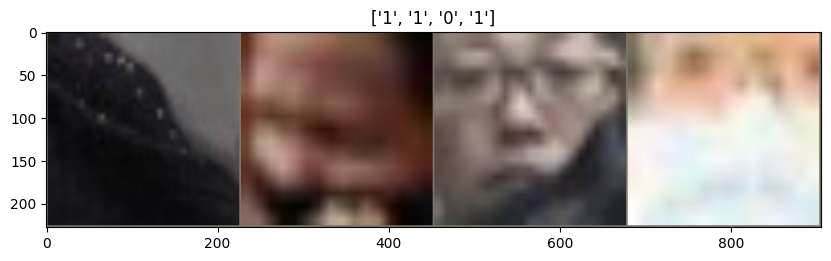

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.7MB/s]


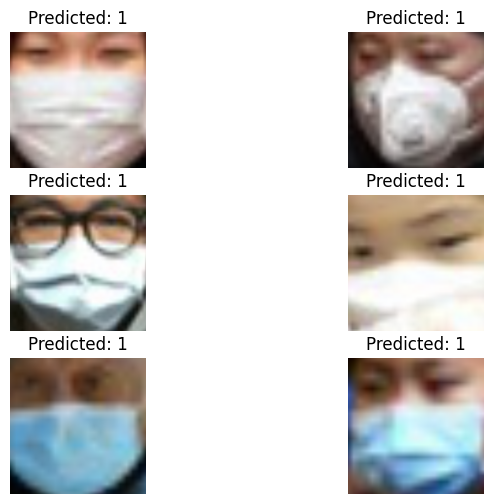

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        51
           1       0.93      0.99      0.96       388
           2       0.00      0.00      0.00        19

    accuracy                           0.92       458
   macro avg       0.60      0.58      0.59       458
weighted avg       0.88      0.92      0.90       458



NameError: ignored

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset_CNN.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2023_CW_Dataset_CNN.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset_CNN.zip


data_dir = 'CV2023_CW_Dataset_CNN'
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=[class_names[x] for x in first_classes])
plt.show()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            #epoch loss and accuracy are calculated
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'test' and epoch_acc > best_acc:
                # best epoch accuracy is updated
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Define the number of classes in your problem
num_classes = 3

from train_CNN import train_CNN
##############################################################################
# TODO: use ResNet18 as feature extractor                                    #
##############################################################################
# Modify the model to output the desired number of classes
model_ft = train_CNN(model_ft, num_classes)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# sets up the stochastic gradient descent optimizer to update only the parameters of the final layer.
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft.load_state_dict(torch.load(os.path.join(MODEL_PATH,'CNN_original_Dataset.pth')))

plt.figure(figsize=(8, 6))
visualize_model(model_ft)
plt.show()

from sklearn.metrics import classification_report

# Set model to evaluate mode
model_ft.eval()

# Get predictions on test data
y_preds = []
y_true = []
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.tolist())
        y_true.extend(labels.tolist())

# Compute classification report
print(classification_report(y_true, y_preds, zero_division=0))

# CNN Personal Dataset

cuda:0


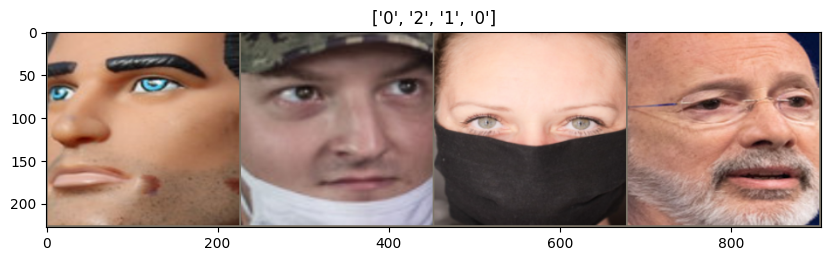

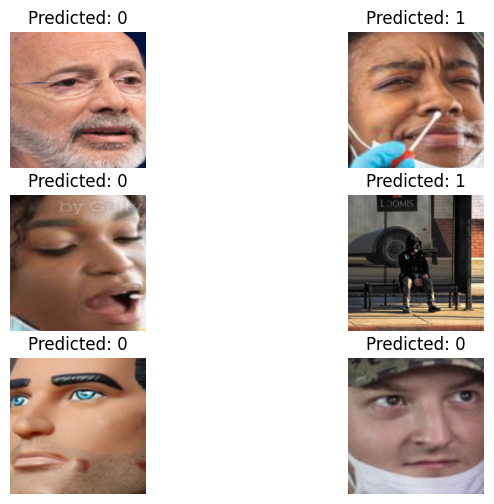

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.64      1.00      0.78         9
           2       0.00      0.00      0.00         7

    accuracy                           0.62        24
   macro avg       0.41      0.58      0.48        24
weighted avg       0.44      0.62      0.52        24



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset/ownTestCNN.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q ownTestCNN.zip

# Delete zipped version from Colab (not from Drive)
!rm ownTestCNN.zip

data_dir = 'ownTestCNN'
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

mtcnn = MTCNN(keep_all=True)

def crop_face(image):
    image = np.array(image)
    faces, _ = mtcnn.detect(image, landmarks=False)
    if faces is not None:
        # crop image using the first detected face
        x1, y1, x2, y2 = faces[0].astype(int)
        cropped_image = Image.fromarray(image[y1:y2, x1:x2])
        cropped_image = cropped_image.resize((224, 224), resample=Image.BILINEAR)  # resize to 224x224
        return cropped_image
    else:
        return Image.fromarray(image)


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'ownTest': transforms.Compose([
        transforms.Lambda(crop_face), # crop image based on detected face
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'ownTest']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'ownTest']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'ownTest']}
class_names = image_datasets['train'].classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['ownTest']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=[class_names[x] for x in first_classes])
plt.show()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        for phase in ['train', 'ownTest']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'ownTest' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['ownTest']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Define the number of classes in your problem
num_classes = 3

from train_CNN import train_CNN
##############################################################################
# TODO: use ResNet18 as feature extractor                                    #
##############################################################################
# Modify the model to output the desired number of classes
model_ft = train_CNN(model_ft, num_classes)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_ft.load_state_dict(torch.load(os.path.join(MODEL_PATH,'CNN_personal_Datset.pth')))


plt.figure(figsize=(8, 6))
visualize_model(model_ft)
plt.show()

from sklearn.metrics import classification_report

# Set model to evaluate mode
model_ft.eval()

# Get predictions on test data
y_preds = []
y_true = []
for inputs, labels in dataloaders['ownTest']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.tolist())
        y_true.extend(labels.tolist())

# Compute classification report
print(classification_report(y_true, y_preds, zero_division=0))

# SVM + SIFT CW_DATASET MaskDetection Function

In [3]:
CW_DATASET_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset')
sys.path.append(CW_DATASET_PATH)

PERSONAL_DATASET_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
sys.path.append(PERSONAL_DATASET_PATH)

In [4]:
model_type = load(os.path.join(MODEL_PATH, 'SVM_SIFT_CWDataset.joblib'))
path_to_testset = os.path.join(CW_DATASET_PATH, 'CV2023_CW_Dataset.zip')
sys.path.append(PERSONAL_DATASET_PATH)

In [5]:
def MaskDetection(path_to_testset, model_type):


    # Identify path to zipped dataset
  zip_path = path_to_testset

  # Copy it to Colab
  !cp '{zip_path}' .

  # Unzip it
  !yes|unzip -q CV2023_CW_Dataset.zip

  # Delete zipped version from Colab (not from Drive)
  !rm CV2023_CW_Dataset.zip


  def load_images_and_labels(train_path, test_path):
      images = []
      labels = []

      # Load images and labels from train folder
      train_images_path = os.path.join(train_path, 'images')
      train_labels_path = os.path.join(train_path, 'labels')
      train_img_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpeg')]
      for img_file in train_img_files:
          # Load the image and append to images list
          img_path = os.path.join(train_images_path, img_file)
          #print('Loading image:', img_path)
          image = io.imread(img_path)
          images.append(image)

          # Load the label if it exists and append to labels list
          label_path = os.path.join(train_labels_path, img_file[:-5] + '.txt')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  label = int(f.read().strip())
              labels.append(label)
              #print('Label for image', img_path, ':', label)
          else:
              None

      # Load images and labels from test folder
      test_images_path = os.path.join(test_path, 'images')
      test_labels_path = os.path.join(test_path, 'labels')
      test_img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpeg')]
      for img_file in test_img_files:
          # Load the image and append to images list
          img_path = os.path.join(test_images_path, img_file)
          #print('Loading image:', img_path)
          image = io.imread(img_path)
          images.append(image)

          # Load the label if it exists and append to labels list
          label_path = os.path.join(test_labels_path, img_file[:-5] + '.txt')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  label = int(f.read().strip())
              labels.append(label)
              #print('Label for image', img_path, ':', label)
          else:
              None

      # Count the number of images per label class
      label_counts = Counter(labels)
      print('Number of images per label class:', label_counts)

      return images, labels, label_counts


  train_path = 'train'
  test_path = 'test'
  images, labels, label_counts = load_images_and_labels(train_path, test_path)

  # Split the data into training and test sets, stratified by the labels
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

  # Initialize SIFT detector
  sift = cv2.SIFT_create()

  # Create empty lists for feature descriptors and labels
  des_list = []
  y_train_list = []

  #fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)

  # Define target size
  target_size = (256, 256)

  # Loop over each image in the training set
  for i in range(len(X_train)):
      # Load the image and resize to target size
      img = cv2.resize(X_train[i], target_size)
      
      # Convert to grayscale
      img_gray = img_as_ubyte(color.rgb2gray(img))
      
      # Detect keypoints and extract descriptors with SIFT
      kp, des = sift.detectAndCompute(img_gray, None)
  

      # Append list of descriptors and label to respective lists
      if des is not None:
          des_list.append(des)
          y_train_list.append(y_train[i])

  # Convert to array for easier handling
  des_array = np.vstack(des_list)


  ## Clustering the descriptors
  # Number of centroids/codewords: good rule of thumb is 10*num_classes
  k = len(np.unique(y_train)) * 10

  # Use MiniBatchKMeans for faster computation and lower memory usage
  batch_size = des_array.shape[0] // 4
  kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

  # Load a test image
  test_img = X_train[0]
  test_img_gray = img_as_ubyte(color.rgb2gray(test_img))

  # Detect keypoints and extract descriptors with SIFT
  kp, des = sift.detectAndCompute(test_img_gray, None)

  # Predict visual words for the descriptors using the trained KMeans model
  visual_words = kmeans.predict(des)

  print(visual_words)

  # Convert descriptors into histograms of codewords for each image
  hist_list = []
  idx_list = []

  for des in des_list:
      hist = np.zeros(k)

      idx = kmeans.predict(des)
      idx_list.append(idx)
      for j in idx:
          hist[j] = hist[j] + (1 / len(des))
      hist_list.append(hist)

  hist_array = np.vstack(hist_list)
  
  ########################################
  # Call model type
  classifier = model_type

  hist_list = []

  for i in range(len(X_test)):
      img = img_as_ubyte(color.rgb2gray(X_test[i]))
      kp, des = sift.detectAndCompute(img, None)

      if des is not None:
          hist = np.zeros(k)

          idx = kmeans.predict(des)

          for j in idx:
              hist[j] = hist[j] + (1 / len(des))

          # hist = scale.transform(hist.reshape(1, -1))
          hist_list.append(hist)

      else:
          hist_list.append(None)

  # Remove potential cases of images with no descriptors
  idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
  hist_list = [hist_list[i] for i in idx_not_empty]
  y_test = [y_test[i] for i in idx_not_empty]
  hist_array = np.vstack(hist_list)

  ## Predict the classes of each test image
  y_pred = classifier.predict(hist_array).tolist()


  fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)
  ax = axes.ravel()

  random_indices = random.sample(range(len(X_test)), 4)

  for i in range(4):
      ax[i].imshow(X_test[random_indices[i]])
      ax[i].set_title(f'Label: {y_test[random_indices[i]]} \n Prediction: {y_pred[random_indices[i]]}')
      ax[i].set_axis_off()

  fig.tight_layout()
  plt.show()

Number of images per label class: Counter({1: 2328, 0: 427, 2: 97})


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[15 14 17 10 24 12 28 13]


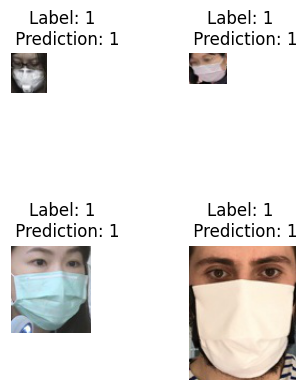

In [6]:
MaskDetection(path_to_testset, model_type)

# SIFT + SVM Personal Datase MaskDetection Function

Unexpected error that I was unable to solve in this code section, please see video demo for more information. run SIFT + SVM Personal Dataset in the next section.

In [7]:
CW_DATASET_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset')
sys.path.append(CW_DATASET_PATH)

PERSONAL_DATASET_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
sys.path.append(PERSONAL_DATASET_PATH)

In [8]:
model_type = load(os.path.join(MODEL_PATH, 'SVM_SIFT_Personal_Dataset.joblib'))
path_to_testset = os.path.join(PERSONAL_DATASET_PATH, 'ownTest.zip')
sys.path.append(path_to_testset)

In [17]:
def MaskDetection(path_to_testset, model_type):

  # Identify path to zipped dataset
  zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

  # Copy it to Colab
  !cp '{zip_path}' .

  # Unzip it
  !yes|unzip -q CV2023_CW_Dataset.zip

  # Delete zipped version from Colab (not from Drive)
  !rm CV2023_CW_Dataset.zip

  # Identify path to zipped dataset
  zip_path2 = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset/ownTest.zip')

  # Copy it to Colab
  !cp '{zip_path2}' .

  # Unzip it
  !yes|unzip -q ownTest.zip

  # Delete zipped version from Colab (not from Drive)
  !rm ownTest.zip

  ###################################

  def load_images_and_labels(train_path, test_path, own_test_path):
      images = []
      labels = []
      own_images = []
      own_labels = []

      # Load images and labels from train folder
      train_images_path = os.path.join(train_path, 'images')
      train_labels_path = os.path.join(train_path, 'labels')
      train_img_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpeg')]
      for img_file in train_img_files:
          # Load the image and append to images list
          img_path = os.path.join(train_images_path, img_file)
          print('Loading train image:', img_path)
          image = io.imread(img_path)
          images.append(image)

          # Load the label if it exists and append to labels list
          label_path = os.path.join(train_labels_path, img_file[:-5] + '.txt')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  label = int(f.read().strip())
              labels.append(label)
              print('Label for train image', img_path, ':', label)
          else:
              print('No label found for train image:', img_path)

      # Load images and labels from test folder
      test_images_path = os.path.join(test_path, 'images')
      test_labels_path = os.path.join(test_path, 'labels')
      test_img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpeg')]
      for img_file in test_img_files:
          # Load the image and append to images list
          img_path = os.path.join(test_images_path, img_file)
          print('Loading test image:', img_path)
          image = io.imread(img_path)
          images.append(image)

          # Load the label if it exists and append to labels list
          label_path = os.path.join(test_labels_path, img_file[:-5] + '.txt')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  label = int(f.read().strip())
              labels.append(label)
              print('Label for test image', img_path, ':', label)
          else:
              print('No label found for test image:', img_path)

      # Load images and labels from own test folder
      own_test_images_path = os.path.join(own_test_path, 'images')
      own_test_labels_path = os.path.join(own_test_path, 'labels')
      own_test_img_files = [f for f in os.listdir(own_test_images_path) if f.endswith('.jpeg')]
      for img_file in own_test_img_files:
          # Load the image and append to images list
          img_path = os.path.join(own_test_images_path, img_file)
          print('Loading own image:', img_path)
          image = io.imread(img_path)

          mtcnn = MTCNN(keep_all=True) 
          # Detect faces in the image
          faces_MTCNN, _ = mtcnn.detect(image, landmarks=False)

          if faces_MTCNN is not None:
              # Only use the first face detected
              face = faces_MTCNN[0]
              # Crop the image to the detected face
              face_img = image[int(face[1]):int(face[3]), int(face[0]):int(face[2])]
              own_images.append(face_img)
          else: 
          # Append the original image as is
            own_images.append(image)    

          # Load the label if it exists and append to labels list
          label_path = os.path.join(own_test_labels_path, img_file[:-5] + '.txt')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  label = int(f.read().strip())
              own_labels.append(label)
              print('Label for own test image', img_path, ':', label)
          else:
              print('No label found for image:', img_path)

      # Count the number of images per label class
      label_counts = Counter(labels + own_labels)
      print('Number of images per label class:', label_counts)

      return images, own_images, labels, own_labels, label_counts


  ###############################################
  train_path = 'train'
  test_path = 'test'
  own_test_path = 'ownTest'
  images, X_own_test, labels, y_own_test , label_counts = load_images_and_labels(train_path, test_path, own_test_path)

  # plot the images
  fig, axes = plt.subplots(nrows=1, ncols=len(X_own_test), figsize=(12, 6))
  for i, image in enumerate(X_own_test):
      axes[i].imshow(image)
      axes[i].axis('off')
  plt.show()


  # Tes if image has loaded correctly
  # Generate 1 random index for a train image
  train_idx = np.random.choice(range(len(images)), size=1, replace=False)[0]
  train_filtered_image = images[train_idx]
  train_filtered_label = labels[train_idx]

  # Generate 1 random index for a test image
  test_index = np.random.choice(range(len(images)-1), size=1, replace=False)[0]
  test_filtered_image = images[test_index]
  test_filtered_label = labels[test_index]

  # Plot the random train image
  fig, axs = plt.subplots(1, 2, figsize=(4, 2))
  axs[0].imshow(train_filtered_image)
  axs[0].set_title('Train Image Label: ' + str(train_filtered_label))

  # Plot the random test image
  axs[1].imshow(test_filtered_image)
  axs[1].set_title('Test Image Label: ' + str(test_filtered_label))

  plt.tight_layout()
  plt.show()


  # Unbalanced problem
  # Split the data into training and test sets, stratified by the labels
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

  # Initialize SIFT detector
  sift = cv2.SIFT_create()

  # Create empty lists for feature descriptors and labels
  des_list = []
  y_train_list = []

  fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)

  # Define target size
  target_size = (256, 256)

  # Loop over each image in the training set
  for i in range(len(X_train)):
      # Load the image and resize to target size
      img = cv2.resize(X_train[i], target_size)
      
      # Convert to grayscale
      img_gray = img_as_ubyte(color.rgb2gray(img))
      
      # Detect keypoints and extract descriptors with SIFT
      kp, des = sift.detectAndCompute(img_gray, None)

      # Show results for first 10 images
      if i < 10:
          row, col = i // 5, i % 5
          img_with_SIFT = cv2.drawKeypoints(img_gray, kp, img_gray)
          ax[row][col].imshow(img_with_SIFT)
          ax[row][col].set_axis_off()

      # Append list of descriptors and label to respective lists
      if des is not None:
          des_list.append(des)
          y_train_list.append(y_train[i])

  # Convert to array for easier handling
  des_array = np.vstack(des_list)


  ###################################################################
  #Clustering the descriptors
  from sklearn.cluster import MiniBatchKMeans
  # Number of centroids/codewords: good rule of thumb is 10*num_classes
  k = len(np.unique(y_train)) * 10

  # Use MiniBatchKMeans for faster computation and lower memory usage
  batch_size = des_array.shape[0] // 4
  kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)


  ###################################################################
  # Testing clustering Clustering the descriptors
  # Load a test image
  test_img = X_train[0]
  test_img_gray = img_as_ubyte(color.rgb2gray(test_img))

  # Detect keypoints and extract descriptors with SIFT
  kp, des = sift.detectAndCompute(test_img_gray, None)

  # Predict visual words for the descriptors using the trained KMeans model
  visual_words = kmeans.predict(des)

  print(visual_words)


  ####################################################################
  # Load a test image
  test_img = X_own_test[0]

  # Convert the resized image to grayscale
  test_img_gray = img_as_ubyte(color.rgb2gray(test_img))

  # Detect keypoints and extract descriptors with SIFT
  kp, des = sift.detectAndCompute(test_img_gray, None)

  # Predict visual words for the descriptors using the trained KMeans model
  visual_words = kmeans.predict(des)

  print(visual_words)


  ####################################################################
  # Generate historgrams of codewords
  # Convert descriptors into histograms of codewords for each image
  hist_list = []
  idx_list = []

  for des in des_list:
      hist = np.zeros(k)

      idx = kmeans.predict(des)
      idx_list.append(idx)
      for j in idx:
          hist[j] = hist[j] + (1 / len(des))
      hist_list.append(hist)

  hist_array = np.vstack(hist_list)

  fig, ax = plt.subplots(figsize=(8, 3))
  ax.hist(np.array(idx_list, dtype=object), bins=k)
  ax.set_title('Codewords occurrence in training set')
  plt.show()


  classifier = load(os.path.join(MODEL_PATH,'SVM_SIFT_Personal_Dataset.joblib')) 

  hist_list = []

  for i in range(len(X_own_test)):
      img = img_as_ubyte(color.rgb2gray(X_own_test[i]))
      kp, des = sift.detectAndCompute(img, None)

      if des is not None:
          hist = np.zeros(k)

          idx = kmeans.predict(des)

          for j in idx:
              hist[j] = hist[j] + (1 / len(des))

          # hist = scale.transform(hist.reshape(1, -1))
          hist_list.append(hist)

      else:
          hist_list.append(None)

  # Remove potential cases of images with no descriptors
  idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
  hist_list = [hist_list[i] for i in idx_not_empty]
  y_own_test = [y_own_test[i] for i in idx_not_empty]
  hist_array = np.vstack(hist_list)


  ##########################################################################
  # Predict the classes of each test image
  y_pred = classifier.predict(hist_array).tolist()

  import numpy as np

  # Generate 4 random indices
  random_indices = np.random.choice(len(X_own_test), size=4, replace=False)

  # Plot the corresponding images
  fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
  ax = axes.ravel()

  for i, idx in enumerate(random_indices):
      ax[i].imshow(X_own_test[idx])
      ax[i].set_title(f'Label: {y_own_test[idx]} \n Prediction: {y_pred[idx]}')
      ax[i].set_axis_off()

  fig.tight_layout()
  plt.show()

  from sklearn import metrics

  print(f"""Classification report for classifier {classifier}:
        {metrics.classification_report(y_own_test, y_pred, zero_division=0)}\n""")

  metrics.ConfusionMatrixDisplay.from_predictions(y_own_test, y_pred)
  plt.show()

Streaming output truncated to the last 5000 lines.
Label for train image train/images/image_0574.jpeg : 2
Loading train image: train/images/image_1805.jpeg
Label for train image train/images/image_1805.jpeg : 0
Loading train image: train/images/image_0248.jpeg
Label for train image train/images/image_0248.jpeg : 0
Loading train image: train/images/image_1856.jpeg
Label for train image train/images/image_1856.jpeg : 1
Loading train image: train/images/image_1034.jpeg
Label for train image train/images/image_1034.jpeg : 0
Loading train image: train/images/image_1744.jpeg
Label for train image train/images/image_1744.jpeg : 1
Loading train image: train/images/image_2034.jpeg
Label for train image train/images/image_2034.jpeg : 1
Loading train image: train/images/image_0819.jpeg
Label for train image train/images/image_0819.jpeg : 1
Loading train image: train/images/image_1990.jpeg
Label for train image train/images/image_1990.jpeg : 1
Loading train image: train/images/image_0257.jpeg
Labe

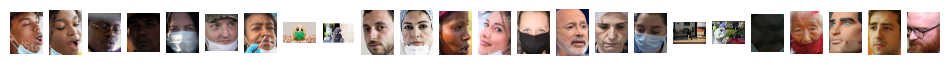

UnboundLocalError: ignored

In [18]:
MaskDetection(path_to_testset, model_type)

# SIFT + SVM Personal Dataset

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

# Identify path to zipped dataset
zip_path2 = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset/ownTest.zip')

# Copy it to Colab
!cp '{zip_path2}' .

# Unzip it
!yes|unzip -q ownTest.zip

# Delete zipped version from Colab (not from Drive)
!rm ownTest.zip

###################################

def load_images_and_labels(train_path, test_path, own_test_path):
    images = []
    labels = []
    own_images = []
    own_labels = []

    # Load images and labels from train folder
    train_images_path = os.path.join(train_path, 'images')
    train_labels_path = os.path.join(train_path, 'labels')
    train_img_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpeg')]
    for img_file in train_img_files:
        # Load the image and append to images list
        img_path = os.path.join(train_images_path, img_file)
        #print('Loading train image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(train_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            #print('Label for train image', img_path, ':', label)
        else:
              None

    # Load images and labels from test folder
    test_images_path = os.path.join(test_path, 'images')
    test_labels_path = os.path.join(test_path, 'labels')
    test_img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpeg')]
    for img_file in test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(test_images_path, img_file)
        #print('Loading test image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            #print('Label for test image', img_path, ':', label)
        else:
              None

    # Load images and labels from own test folder
    own_test_images_path = os.path.join(own_test_path, 'images')
    own_test_labels_path = os.path.join(own_test_path, 'labels')
    own_test_img_files = [f for f in os.listdir(own_test_images_path) if f.endswith('.jpeg')]
    for img_file in own_test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(own_test_images_path, img_file)
        #print('Loading own image:', img_path)
        image = io.imread(img_path)

        mtcnn = MTCNN(keep_all=True) 
        # Detect faces in the image
        faces_MTCNN, _ = mtcnn.detect(image, landmarks=False)

        if faces_MTCNN is not None:
            # Only use the first face detected
            face = faces_MTCNN[0]
            # Crop the image to the detected face
            face_img = image[int(face[1]):int(face[3]), int(face[0]):int(face[2])]
            own_images.append(face_img)
        else: 
        # Append the original image as is
          own_images.append(image)    

        # Load the label if it exists and append to labels list
        label_path = os.path.join(own_test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            own_labels.append(label)
            #print('Label for own test image', img_path, ':', label)
        else:
              None

    # Count the number of images per label class
    label_counts = Counter(labels + own_labels)
    #print('Number of images per label class:', label_counts)

    return images, own_images, labels, own_labels, label_counts


###############################################
train_path = 'train'
test_path = 'test'
own_test_path = 'ownTest'
images, X_own_test, labels, y_own_test , label_counts = load_images_and_labels(train_path, test_path, own_test_path)


# Unbalanced problem
# Split the data into training and test sets, stratified by the labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

# Define target size
target_size = (256, 256)

# Loop over each image in the training set
for i in range(len(X_train)):
    # Load the image and resize to target size
    img = cv2.resize(X_train[i], target_size)
    
    # Convert to grayscale
    img_gray = img_as_ubyte(color.rgb2gray(img))
    
    # Detect keypoints and extract descriptors with SIFT
    kp, des = sift.detectAndCompute(img_gray, None)


    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

# Convert to array for easier handling
des_array = np.vstack(des_list)


###################################################################
#Clustering the descriptors
from sklearn.cluster import MiniBatchKMeans
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)


###################################################################
# Testing clustering Clustering the descriptors
# Load a test image
test_img = X_train[0]
test_img_gray = img_as_ubyte(color.rgb2gray(test_img))

# Detect keypoints and extract descriptors with SIFT
kp, des = sift.detectAndCompute(test_img_gray, None)

# Predict visual words for the descriptors using the trained KMeans model
visual_words = kmeans.predict(des)

#print(visual_words)


####################################################################
# Load a test image
test_img = X_own_test[0]

# Convert the resized image to grayscale
test_img_gray = img_as_ubyte(color.rgb2gray(test_img))

# Detect keypoints and extract descriptors with SIFT
kp, des = sift.detectAndCompute(test_img_gray, None)

# Predict visual words for the descriptors using the trained KMeans model
visual_words = kmeans.predict(des)

#print(visual_words)


####################################################################
# Generate historgrams of codewords
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

classifier = load(os.path.join(MODEL_PATH,'SVM_SIFT_Personal_Dataset.joblib')) 

hist_list = []

for i in range(len(X_own_test)):
    img = img_as_ubyte(color.rgb2gray(X_own_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_own_test = [y_own_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)


##########################################################################
# Predict the classes of each test image
y_pred = classifier.predict(hist_array).tolist()

import numpy as np

# Generate 4 random indices
random_indices = np.random.choice(len(X_own_test), size=4, replace=False)

# Plot the corresponding images
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

for i, idx in enumerate(random_indices):
    ax[i].imshow(X_own_test[idx])
    ax[i].set_title(f'Label: {y_own_test[idx]} \n Prediction: {y_pred[idx]}')
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

# HOG + MLP CW_Dataset MaskDetection Function

In [22]:
CW_DATASET_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset')
sys.path.append(CW_DATASET_PATH)

PERSONAL_DATASET_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
sys.path.append(PERSONAL_DATASET_PATH)

In [23]:
model_type = load(os.path.join(MODEL_PATH, 'HOG_MLP_CWDataset.joblib'))
path_to_testset = os.path.join(CW_DATASET_PATH, 'CV2023_CW_Dataset.zip')
sys.path.append(PERSONAL_DATASET_PATH)

In [24]:
def MaskDetection(path_to_testset, model_type): 
  # Identify path to zipped dataset
  zip_path = path_to_testset

  # Copy it to Colab
  !cp '{zip_path}' .

  # Unzip it
  !yes|unzip -q CV2023_CW_Dataset.zip

  # Delete zipped version from Colab (not from Drive)
  !rm CV2023_CW_Dataset.zip


  def load_images_and_labels(train_path, test_path):
      images = []
      labels = []

      # Load images and labels from train folder
      train_images_path = os.path.join(train_path, 'images')
      train_labels_path = os.path.join(train_path, 'labels')
      train_img_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpeg')]
      for img_file in train_img_files:
          # Load the image and append to images list
          img_path = os.path.join(train_images_path, img_file)
          print('Loading image:', img_path)
          image = io.imread(img_path)
          images.append(image)

          # Load the label if it exists and append to labels list
          label_path = os.path.join(train_labels_path, img_file[:-5] + '.txt')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  label = int(f.read().strip())
              labels.append(label)
              print('Label for image', img_path, ':', label)
          else:
              print('No label found for image:', img_path)

      # Load images and labels from test folder
      test_images_path = os.path.join(test_path, 'images')
      test_labels_path = os.path.join(test_path, 'labels')
      test_img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpeg')]
      for img_file in test_img_files:
          # Load the image and append to images list
          img_path = os.path.join(test_images_path, img_file)
          #print('Loading image:', img_path)
          image = io.imread(img_path)
          images.append(image)

          # Load the label if it exists and append to labels list
          label_path = os.path.join(test_labels_path, img_file[:-5] + '.txt')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  label = int(f.read().strip())
              labels.append(label)
              #print('Label for image', img_path, ':', label)
          else:
              print('No label found for image:', img_path)

      # Count the number of images per label class
      label_counts = Counter(labels)
      print('Number of images per label class:', label_counts)

      return images, labels, label_counts

  ##############################################################################
  train_path = 'train'
  test_path = 'test'
  images, labels, label_counts = load_images_and_labels(train_path, test_path)

  # Tes if image has loaded correctly
  # Generate 1 random index for a train image
  train_idx = np.random.choice(range(len(images)), size=1, replace=False)[0]
  train_filtered_image = images[train_idx]
  train_filtered_label = labels[train_idx]

  # Generate 1 random index for a test image
  test_index = np.random.choice(range(len(images)-1), size=1, replace=False)[0]
  test_filtered_image = images[test_index]
  test_filtered_label = labels[test_index]

  # Plot the random train image
  fig, axs = plt.subplots(1, 2, figsize=(4, 2))
  axs[0].imshow(train_filtered_image)
  axs[0].set_title('Train Image Label: ' + str(train_filtered_label))

  # Plot the random test image
  axs[1].imshow(test_filtered_image)
  axs[1].set_title('Test Image Label: ' + str(test_filtered_label))

  plt.tight_layout()
  plt.show()


  # Unbalanced problem
  # Split the data into training and test sets, stratified by the labels
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

  # Create empty lists for feature descriptors and labels
  des_list = []
  y_train_list = []

  fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)

  # Define target size
  target_size = (256, 256)

  # Loop over each image in the training set
  for i in range(len(X_train)):
      # Load the image and resize to target size
      img = cv2.resize(X_train[i], target_size)

      # Convert to grayscale
      img_gray = img_as_ubyte(color.rgb2gray(img))

      # Compute HOG features
      kp, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), visualize=True)

      # Show results for first 5 images
      if i < 5:
          row, col = i // 5, i % 5
          ax[row][col].imshow(hog_image, cmap=plt.cm.gray)
          ax[row][col].set_axis_off()

      # Append list of descriptors and label to respective lists
      if kp is not None:
          des_list.append(kp)
          y_train_list.append(y_train[i])

  # Convert to array for easier handling
  des_array = np.vstack(des_list)

  classifier = model_type

  ##########################################################################
  # Predict the classes of each test image
  y_pred = classifier.predict(des_array)

  # Generate 4 random indices
  random_indices = np.random.choice(len(X_test), size=4, replace=False)

  # Plot the corresponding images
  fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
  ax = axes.ravel()

  for i, idx in enumerate(random_indices):
      ax[i].imshow(X_test[idx])
      ax[i].set_title(f'Label: {y_test[idx]} \n Prediction: {y_pred[idx]}')
      ax[i].set_axis_off()

  fig.tight_layout()
  plt.show()

In [ ]:
MaskDetection(path_to_testset, model_type)